In [49]:
#from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
import glob
import json
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from PIL import Image

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
import keras
import keras.models as models

from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import BatchNormalization,Input, Cropping2D 

from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers.convolutional import Convolution2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Model
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2
from random import shuffle
from PIL import Image

print('OK')

OK


#### Load the dataset

In [50]:
seg_train_x_images = glob.glob("data/gtCoarse/train/*/*_color.png")
seg_test_x_images = glob.glob("data/gtCoarse/test/*/*_color.png")

ori_train_x_images = glob.glob("data/leftImg8bit/train/*/*.png")
ori_test_x_images = glob.glob("data/leftImg8bit/test/*/*.png")

In [51]:
print ('total segemnted training dataset size:' , len(seg_train_x_images))
print ('total segmented test dataset size:' , len(seg_test_x_images))

print ('total original training dataset size:' , len(ori_train_x_images))
print ('total original test dataset size:' , len(ori_test_x_images))

total segemnted training dataset size: 1036
total segmented test dataset size: 1203
total original training dataset size: 1036
total original test dataset size: 1203


#### Split dataset

In [54]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ori_train_x_images, test_size=0.2)

print ('train size : ' , len(train))
print ('test size : ', len(test))

train size :  828
test size :  208


#### Utility functions

In [55]:
def show_plot(x1,x2):
    # Two subplots, unpack the axes array immediately
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(x1)
    ax2.imshow(x2)
    plt.show()
    
def read_json(dir_):
    json_data=open(dir_).read()
    data = json.loads(json_data)
    return data

def read_steering_angle(dir_):
    img_dir = dir_.replace("leftImg8bit","")
    img_dir = img_dir.replace(".png","")
    img_dir_1 = img_dir.split('/')[-1]
    img_dir_2 = img_dir.split('/')[-2]
    
    data_dir =  'data/vehicle/train/' + img_dir_2 + '/' + img_dir_1 + 'vehicle.json'
    
    json_data = read_json(data_dir)
    data_dic[img_dir_1] = json_data
    
    return (data_dic[img_dir_1]['yawRate']) 

print ('OK')

OK


image dir: data/leftImg8bit/train/01_Hanns_Klemm_Str_45/01_Hanns_Klemm_Str_45_000004_000100_leftImg8bit.png
image size:  (512, 1024, 3)
-0.02029048774908853


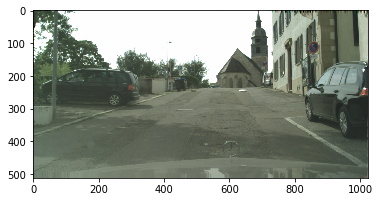

In [73]:
idx = 10
x = mpimg.imread(train[idx])
x = cv2.resize(x,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
print ('image dir:' , train[0])
print ('image size: ' , x.shape)
print (read_steering_angle(train[idx]))

plt.imshow(x); plt.show()


#### Dataset exploration

data//train/11_Parkplatz_Flugfeld/11_Parkplatz_Flugfeld_000000_000160_*
original dir :  data/leftImg8bit/train/11_Parkplatz_Flugfeld/11_Parkplatz_Flugfeld_000000_000160_leftImg8bit.png
constructed dir :  data/gtCoarse/train/11_Parkplatz_Flugfeld/11_Parkplatz_Flugfeld_000000_000160_*color.png


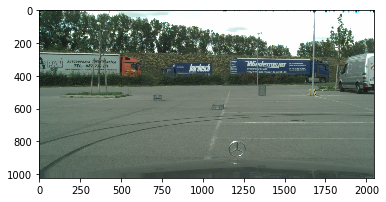

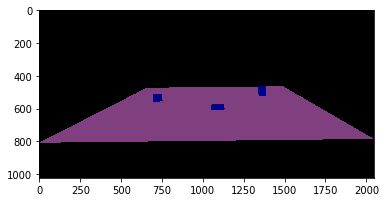

In [5]:
index = 12
img_dir = ori_train_x_images[index].replace("leftImg8bit","")
img_dir = img_dir.replace(".png","*")
print (img_dir)

img_dir_1 = img_dir.split('/')[-1]
img_dir_2 = img_dir.split('/')[-2]

data_dir = "data/gtCoarse/train/" +  img_dir_2 + '/' + img_dir_1 + 'color.png'


print('original dir : ' , ori_train_x_images[index])
print ('constructed dir : ', data_dir)

con_img = glob.glob(data_dir)

x = mpimg.imread(ori_train_x_images[index])
y = mpimg.imread(con_img[0])

plt.imshow(x); plt.show()
plt.imshow(y); plt.show()

#show_plot(x,y)

data_dic = {}
train_x = []
train_y = []

for i in range(len(ori_train_x_images)):
    img_dir = ori_train_x_images[i].replace("leftImg8bit","")
    img_dir = img_dir.replace(".png","")
    img_dir_1 = img_dir.split('/')[-1]
    img_dir_2 = img_dir.split('/')[-2]
    
    seg_img_dir = "data/gtCoarse/train/" +  img_dir_2 + '/' + img_dir_1 + '*color.png'
    data_dir =  'data/vehicle/train/' + img_dir_2 + '/' + img_dir_1 + 'vehicle.json'
    
    #print(data_dir)
    
    
    con_img = glob.glob(seg_img_dir)
    json_data = read_json(data_dir)
    data_dic[img_dir_1] = json_data
    
    
    #x = mpimg.imread(ori_train_x_images[i])
    #y = mpimg.imread(con_img[0])
    
    train_x.append(ori_train_x_images[i])
    #train_y.append(con_img[0])
    train_y.append(data_dic[img_dir_1]['yawRate'])
    #print (data_dic[img_dir_1]['yawRate'])
    #show_plot(x,y)


In [6]:

print ('train x image size : ' , len(train_x))
print ('train y yawrate size: ' , len(train_y))
print (train_x[3])
print (train_y[3])
#for i in range(len(test_x_images)):
#    x = mpimg.imread(test_x_images[i])
#    plt.imshow(x, cmap='gray')
#    plt.title(test_x_images[i])
#    plt.show()

train x image size :  1036
train y yawrate size:  1036
data/leftImg8bit/train/11_Parkplatz_Flugfeld/11_Parkplatz_Flugfeld_000000_000130_leftImg8bit.png
-0.008433651273792352


In [ ]:
import random
idx = random.randint(0,len(train_x))

x = mpimg.imread(train_x[idx])
y = mpimg.imread(train_y[idx])

#json_data_idx = train_x[idx].split('/')[-1]
show_plot(x,y)
print (train_x[idx])
img_dir = ori_train_x_images[idx].replace("leftImg8bit","")
img_dir = img_dir.replace(".png","")
img_dir_1 = img_dir.split('/')[-1]
    

print ('Yaw Rate : ' , data_dic[img_dir_1]['yawRate'] )

In [7]:
### load the ground label file
print (x*255)

print (x.shape)


h , w , c = x.shape

zero = np.zeros((h,w,c))

idx , idy , ch = (np.where(x*255 > 150))

print (idx,idy,ch)

zero[idx,idy,:] = 255.0

[[[108. 129. 126.]
  [105. 128. 123.]
  [102. 125. 119.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[192. 202. 197.]
  [184. 195. 190.]
  [177. 189. 183.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[150. 148. 150.]
  [146. 144. 146.]
  [141. 140. 142.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 ...

 [[ 58.  75.  65.]
  [ 58.  76.  68.]
  [ 59.  77.  70.]
  ...
  [ 77.  97.  86.]
  [ 77.  97.  86.]
  [ 77.  97.  86.]]

 [[ 58.  75.  65.]
  [ 58.  76.  69.]
  [ 59.  77.  70.]
  ...
  [ 84. 104. 100.]
  [ 80.  97.  87.]
  [ 80.  97.  87.]]

 [[ 58.  75.  66.]
  [ 58.  76.  69.]
  [ 58.  77.  70.]
  ...
  [ 83. 102.  98.]
  [ 83. 102.  98.]
  [ 83. 102.  98.]]]
(1024, 2048, 3)
[  0   0   0 ... 936 936 936] [ 142  142  142 ... 1206 1207 1208] [0 1 2 ... 1 1 1]


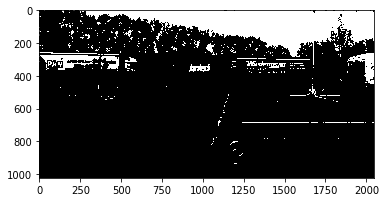

In [8]:
plt.imshow(zero[:,:,0], cmap= 'gray')
plt.show()

In [9]:
#data = json.loads('data/vehicle/test/02_Hanns_Klemm_Str_44/02_Hanns_Klemm_Str_44_000000_000020_vehicle.json')
json_data=open('data/vehicle/test/02_Hanns_Klemm_Str_44/02_Hanns_Klemm_Str_44_000000_000020_vehicle.json').read()
data = json.loads(json_data)
print(data)


#data = json.loads(jdata)

{'gpsHeading': 154, 'gpsLatitude': 48.68054310929056, 'gpsLongitude': 8.976210024000622, 'speed': 1.62925, 'yawRate': -0.01447821870583144}


In [10]:
data['yawRate']

-0.01447821870583144

### End to End Driving Model 

### Fit Generator

In [80]:
import cv2
import numpy as np
import sklearn
images = []
angles = []

def generator(samples, batch_size=32):
    num_samples = len(samples)
    i = 0
    correction = 0.25
    
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                x = mpimg.imread(batch_sample)
                #name_center = 'data/IMG/'+batch_sample[0].split('/')[-1].strip()
                #name_left   = 'data/IMG/'+batch_sample[1].split('/')[-1].strip()
                #name_right  = 'data/IMG/'+batch_sample[2].split('/')[-1].strip()
                x = cv2.resize(x,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
                center_image = np.asarray(x)
                #left_image   = np.asarray(Image.open(name_left))
                #right_image  = np.asarray(Image.open(name_right))
                
                steering_angle = float(read_steering_angle(batch_sample))
                

                images.append(center_image)
                
                angles.append(steering_angle)
                
                #print (batch_sample , steering_angle)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function

train_generator = generator(train, batch_size=1)
validation_generator = generator(test, batch_size=1)

print ('OK')

OK


In [81]:
ch, row, col = 3, 512, 1024  # Trimmed image format

def E2E_Model(input_shape = (row,col,ch)):
    model = Sequential()
    # Preprocess incoming data, centered around zero with small standard deviation 
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=(row, col, ch),output_shape=(row, col, ch)))
    model.add(Cropping2D(cropping=((100,50), (0,0)), input_shape=(row, col, ch)))

    #########################################################
    model.add(Convolution2D(24,5,5,border_mode='valid', W_regularizer=l2(0.001), subsample=(2,2)))
    model.add(ELU())
    model.add(Convolution2D(36,5,5,border_mode='valid',  W_regularizer=l2(0.001), subsample=(2,2)))
    model.add(ELU())
    model.add(Convolution2D(48,5,5,border_mode='valid',  W_regularizer=l2(0.001), subsample=(2,2)))
    model.add(ELU())
    model.add(Convolution2D(64,3,3,border_mode='valid',  W_regularizer=l2(0.001), subsample=(1,1)))
    model.add(ELU())
    model.add(Convolution2D(64,3,3,border_mode='valid',  W_regularizer=l2(0.001), subsample=(1,1)))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Flatten())
    #model.add(Dense(1164, activation='relu'))
    #model.add(ELU())
    #model.add(Dropout(0.5))
    model.add(Dense(100,  W_regularizer=l2(0.001)))
    model.add(ELU())
    #model.add(Dropout(0.5))
    model.add(Dense(50,  W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Dense(10,  W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Dense(1))
    
    return model

In [82]:
model = E2E_Model()

In [83]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_8 (Lambda)            (None, 512, 1024, 3)      0         
_________________________________________________________________
cropping2d_8 (Cropping2D)    (None, 362, 1024, 3)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 179, 510, 24)      1824      
_________________________________________________________________
elu_57 (ELU)                 (None, 179, 510, 24)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 88, 253, 36)       21636     
_________________________________________________________________
elu_58 (ELU)                 (None, 88, 253, 36)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 42, 125, 48)       43248     
__________

In [84]:
model.compile(loss='mse', optimizer='adam')

history_object = model.fit_generator(train_generator, samples_per_epoch= 
            len(train), validation_data=validation_generator, 
            nb_val_samples=len(test), nb_epoch=10)


Epoch 1/10
828/828 [==============================] - 103s 124ms/step - loss: 3346.3109 - val_loss: 6.0498
Epoch 2/10
828/828 [==============================] - 101s 122ms/step - loss: 6.0326 - val_loss: 6.0134
Epoch 3/10
828/828 [==============================] - 102s 123ms/step - loss: 5.9888 - val_loss: 5.9613
Epoch 4/10
828/828 [==============================] - 102s 123ms/step - loss: 5.9269 - val_loss: 5.8888
Epoch 5/10
828/828 [==============================] - 105s 127ms/step - loss: 5.8417 - val_loss: 5.7897
Epoch 6/10
828/828 [==============================] - 107s 129ms/step - loss: 5.7268 - val_loss: 5.6574
Epoch 7/10
828/828 [==============================] - 101s 122ms/step - loss: 5.5741 - val_loss: 5.4827
Epoch 8/10
828/828 [==============================] - 100s 121ms/step - loss: 5.3745 - val_loss: 5.2566
Epoch 9/10
828/828 [==============================] - 98s 119ms/step - loss: 5.1197 - val_loss: 4.9722
Epoch 10/10
828/828 [==============================] - 110s 13

#### Save the model

In [85]:
model.save('model_.h5')
print('Model Saved!')

Model Saved!


#### Model performance

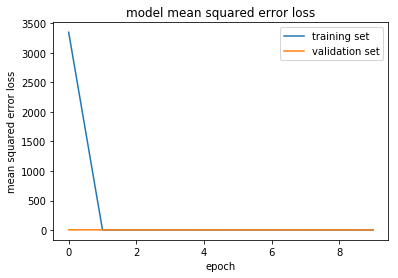

In [86]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

#### Load the model and predict

In [92]:
idx = 10
img_dir = ori_test_x_images[idx]
x = mpimg.imread(img_dir)
x = cv2.resize(x,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
x = np.asarray(x)
steering_angle = float(model.predict(x[None, :, :, :], batch_size=1))
print (steering_angle)

-0.0016217157244682312


In [94]:
def predict(img_dir):
    x = mpimg.imread(img_dir)
    x = cv2.resize(x,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    x = np.asarray(x)
    steering_angle = float(model.predict(x[None, :, :, :], batch_size=1))
    return steering_angle

def read_test_steering_angle(dir_):
    img_dir = dir_.replace("leftImg8bit","")
    img_dir = img_dir.replace(".png","")
    img_dir_1 = img_dir.split('/')[-1]
    img_dir_2 = img_dir.split('/')[-2]
    
    data_dir =  'data/vehicle/test/' + img_dir_2 + '/' + img_dir_1 + 'vehicle.json'
    
    json_data = read_json(data_dir)
    data_dic[img_dir_1] = json_data
    
    return (data_dic[img_dir_1]['yawRate']) 

In [96]:
print (predict(img_dir))
print (read_test_steering_angle(img_dir))

-0.0016217157244682312
0.00864380714621777


In [118]:
import sys
def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '#' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()

In [119]:
error_sum = 0.0
p_angles = []
a_angles = []
count = 0 
total = len(ori_test_x_images)

for i in range(len(ori_test_x_images)):
    img_dir = ori_test_x_images[i]
    p_angle = predict(img_dir)
    a_angle = read_test_steering_angle(img_dir)
    
    p_angles.append(p_angle)
    a_angles.append(a_angle)
    
    progress(count,total)
    count+=1

In [120]:
def mse(predictions, targets):
    return ((predictions - targets) ** 2).mean(axis=0)

In [121]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [122]:
predictions = np.array(p_angles)
targets = np.array(a_angles)
print ('RSME error : ' , rmse(predictions, targets))
print ('MSE error : ' , mse(predictions, targets))

RSME error :  0.024719790658497047
MSE error :  0.0006110680501999179
